# Exploratory Data Analysis
Familiarize with the dataset, we'll try to target question 3. Recall the
question asks "do periods with low meat production track with overall
unemployment numbers?"

## Environment Setup
Load modules, data.

In [85]:
# modules
## external
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## stdlib
from pathlib import Path
from typing import Any, Callable
from pprint import pprint

## utils

In [86]:
# load in datasets
home_dir = Path().cwd().parent                                                  # github repo home dir

## financial data
economic_df = pd.read_csv(
    home_dir / "datasets" / "acs_5yr_est_selected_economic_characteristics_2010-2022.csv",
    engine="c", low_memory=False
)
commodities_df = pd.read_csv(
    home_dir / "datasets" / "all_commodities.csv",
    engine="c", low_memory=False
)
stocks_df = pd.read_csv(
    home_dir / "datasets" / "all_stock_and_etfs.csv",
    engine="c", low_memory=False
)
stock_descr_df = pd.read_csv(
    home_dir / "datasets" / "stock_descriptions.csv",
    engine="c", low_memory=False
)

## meat data
meat_storage_df = pd.read_csv(
    home_dir / "datasets" / "Meat_Stats_Cold_Storage.csv", engine="c",
    low_memory=False
)
meat_production_df = pd.read_csv(
    home_dir / "datasets" / "Meat_Stats_Meat_Production.csv", engine="c",
    low_memory=False
)
meat_slaughter_weights_df = pd.read_csv(
    home_dir / "datasets" / "Meat_Stats_Slaughter_Counts.csv", engine="c",
    low_memory=False
)
meat_slaughter_counts_df = pd.read_csv(
    home_dir / "datasets" / "Meat_Stats_Slaughter_Weights.csv", engine="c",
    low_memory=False
)
nutrition_df = pd.read_csv(
    home_dir / "datasets" / "Nutrition_Physical_Activity_and_Obesity_Data.csv", 
    engine="c", low_memory=False
)

# generate lookup for easy replication downstream
dfs = {
    "economic": economic_df,
    "commodities": commodities_df,
    "stocks": stocks_df,
    "stock_descr": stock_descr_df,
    "meat_storage": meat_storage_df,
    "meat_production": meat_production_df,
    "meat_slaughter_weights": meat_slaughter_weights_df,
    "meat_slaughter_counts": meat_slaughter_counts_df,
    "nutrition": nutrition_df
}

## Exploratory Analysis
Distributions, plots, etc.

In [87]:
# auxiliary fn for easy application
def apply_dfs(dfs: dict[str, pd.DataFrame], fn: Callable) -> dict[str, Any]:
    """Applies fn to all dfs in the lookup.

    Args:
        dfs (dict[str, pd.DataFrame]): lookup
        fn (Callable): function to apply, df is passed as the first parameter

    Returns:
        dict[str, Any]: same keys to the output of the function
    """
    
    return {df_type: fn(df) for df_type, df in dfs.items()}

def pprint_dfs(dfs: dict[str, pd.DataFrame]) -> None:
    """Pretty printing for the dfs lookup.

    Args:
        dfs (dict[str, pd.DataFrame]): lookup
    """
    
    for df_type, df in dfs.items():
        print(f"< ::::::: {df_type.replace('_', ' ').capitalize()} ::::::: >")
        print(df)
        print("\n\n")

In [88]:
# inspection
## inspect rows
pprint_dfs(
    apply_dfs(dfs, pd.DataFrame.head)
)

## inspect distributions
pprint_dfs(
    apply_dfs(dfs, pd.DataFrame.describe)
)

## inspect metadata
apply_dfs(dfs, pd.DataFrame.info)

< ::::::: Economic ::::::: >
               Label (Grouping)           Category    State   Estimate  \
0             EMPLOYMENT STATUS             Header  Alabama        NaN   
1  Population 16 years and over  EMPLOYMENT STATUS  Alabama  3,714,504   
2                In labor force  EMPLOYMENT STATUS  Alabama  2,246,848   
3          Civilian labor force  EMPLOYMENT STATUS  Alabama  2,230,879   
4                      Employed  EMPLOYMENT STATUS  Alabama  2,036,867   

  Margin of Error    Percent Percent Margin of Error  Year  
0             NaN        NaN                     NaN  2010  
1          ±1,588  3,714,504                     (X)  2010  
2          ±5,576      60.5%                    ±0.1  2010  
3          ±5,531      60.1%                    ±0.1  2010  
4          ±5,904      54.8%                    ±0.2  2010  



< ::::::: Commodities ::::::: >
    Date-Time       Value             Unit Commodity
0  2024-01-01  203.879130  Cents per Pound    Coffee
1  2023-12-01  210.

{'economic': None,
 'commodities': None,
 'stocks': None,
 'stock_descr': None,
 'meat_storage': None,
 'meat_production': None,
 'meat_slaughter_weights': None,
 'meat_slaughter_counts': None,
 'nutrition': None}

## Cleaning
Removing NA, reformatting, etc.

The data about economics trends is particularly useful for finding the
unemployment in the states with highest meat production, etc. Data about
commodities can tell us how the price of meat corresponds to meat production,
although this veers more into question 1.

Data about meat production is of course essential as well. Some supplementary
insights can be found in slaughter weights and counts since that directly
relates to the rate of meat production, as well as meat storage since more meat
that stored means less meat is needed to be produced. Some of this info may be
redundant, but it's good to not remove too much data at once.

In [89]:
# only keep useful datasets
useful_dfs = [
    "economic", "meat_storage", "meat_production",
    "meat_slaughter_weights", "meat_slaughter_counts"
]
dfs = {k: dfs[k] for k in useful_dfs}

### Cleaning Functions
Date inference, timeline correction, etc.

In [90]:
# Auxiliary Fn
def convert_dates(df: pd.DataFrame) -> pd.DataFrame:
    """Creates a "date" column given month and year.

    Args:
        df (pd.DataFrame): dataset

    Returns:
        pd.DataFrame: reference to modified dataset
    """
    
    # create new
    df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"].astype(str), format="%Y-%m")
    return df

### Individual Dataset Cleaning

2010 2022


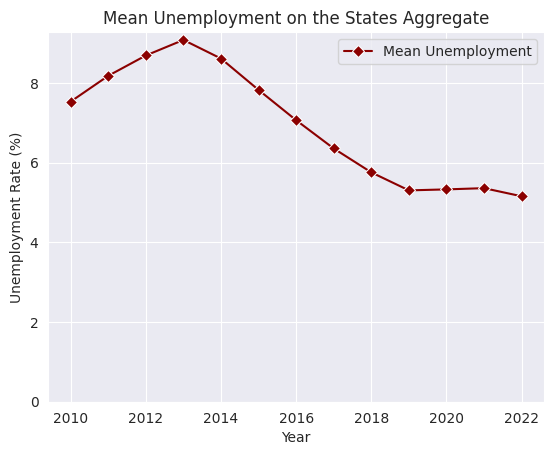

In [91]:
# clean economic data
df = dfs["economic"]
    # print(df.head(10))

## inspect columns
cols = ["Label (Grouping)", "Category"]
    # pprint({col: df[col].unique() for col in cols})

## clean weird artifacts
df["Label (Grouping)"] = df["Label (Grouping)"].str.replace("\xa0", "")
    # pprint({col: df[col].unique() for col in cols})

## only unemployment is needed at this time
df = df[df["Category"].str.lower().str.contains("employment")]
df = df[df["Label (Grouping)"].str.lower().str.contains("unemploy")]

## rename and keep only unemployment rate
df["Label (Grouping)"] = df["Label (Grouping)"].str.replace(
    "Percent Unemployed",
    "Unemployment Rate"
)
df = df[df["Label (Grouping)"] == "Unemployment Rate"]
    # print(df.to_string())
    # pprint({col: df[col].unique() for col in df.columns})
    # print(df.head())

## check if the other cols have any useful info; drop useless ones for now
df = df.drop(columns=[col for col in df.columns if df[col].nunique() <= 1])
    # pprint(df.columns)

## reform to only keep what we need and rename for clarity
keep_cols_renamer = {
    "Year": "year",
    "State": "state",
    "Percent": "unemployment_rate",
    "Percent Margin of Error": "percent_error"
}
df = df[list(keep_cols_renamer.keys())]
df.rename(columns=keep_cols_renamer, inplace=True)

## ensure dtypes
keep_cols_dtype = {
    "year": int,
    "state": str,
    "unemployment_rate": float,
    "percent_error": float
}
df["unemployment_rate"] = df["unemployment_rate"].str[:-1]                      # remove percent sign
df["percent_error"] = df["percent_error"].str[1:]                               # remove +- sign

for col, dtype in keep_cols_dtype.items():
    df[col] = df[col].astype(dtype)

## sort values for visual inspection
df.sort_values(by=["year", "state"], inplace=True)

# update in lookup & export for easy access
dfs["economic"] = df
save_path = Path().cwd().parent / "cleaned-datasets" / f"economic_data.csv"
df.to_csv(
    save_path,
    index=False
)

## grab min and max months for timeline augmentation
print(df["year"].min(), df["year"].max())

## quick graph to visualize
avg_unemployment = df.groupby("year")["unemployment_rate"].mean().reset_index()
sns.set_style("darkgrid")
sns.lineplot(
    avg_unemployment, x="year", y="unemployment_rate", marker="D",
    label="Mean Unemployment", color="darkred"
)
plt.title("Mean Unemployment on the States Aggregate")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.ylim(bottom=0.0)
plt.legend()
plt.show()

## Transformation & Imputations
Fixing formats, merging datasets, and interpolations.

In [92]:
"""
Economic Data
    Since our unemployment rates lack the necessary timesteps for careful lag 
    consideration on a month by month basis, and we'd rather not lose 
    granularity for the production data, we'll instead interpolate unemployment
    rates by state for each month in a year.
    
    To maximize performance, we'll conduct this state-wise first and only then 
    aggregate, thus allowing for the somewhat random deviations within each 
    state's interpolation to cancel out, generating a more accurate aggregate 
    view. In other words, we practically are sampling unemployment rates and 
    taking an aggregation of the sample; thus, by law of large numbers our 
    sample mean will approach the true unemployment rate for a given month, 
    assuming independence between states.
"""

## setup
df = dfs["economic"]

# ## generate date series
# min_year = df["year"].min()
# max_year = df["year"].max()
# date_range = pd.date_range(
#     start=f"{min_year + 1}-01",
#     end=f"{max_year}-12",
#     freq="MS"
# )

# ## setup resulting dataframe to merge with
# date_df = pd.DataFrame(date_range, columns=["date"])
# date_df["date"] = date_df["date"].dt.strftime("%Y-%m")

# ## merge with original; we'll treat the yearly data as 12th month
# yearly_rates = df[df["year"] > min_year][["state", "unemployment_rate"]]
# df["date"] = df["year"].astype(str) + "-12"
# df.drop(columns="year", inplace=True)

# merged_df = pd.merge(
#     date_df, df, how="cross"
# )
# print(merged_df[merged_df["state"] == "California"].to_string())

# ## ensure the first 11 months of data aren't lost
# missing_df = pd.DataFrame({
#     "date": pd.date_range(start=f"{min_year}-01", end=f"{min_year}-11", freq="MS")
# })
# first_year_rates = df[df["year"] == min_year][["state", "unemployment_rate"]]
# missing_df = pd.merge(missing_df, first_year_rates, how="cross")

# ## linear spline interpolation performs the best empirically; perform this 
# ## statewise since it otherwise fails
# for state in merged_df["state"].unique():
#     merged_df.loc[merged_df["state"] == state, "unemployment_rate"] = (
#         merged_df[merged_df["state"] == state]["unemployment_rate"].interpolate(
#             method="spline",
#             order=1
#         )
#     )

# ## add missing months back in & truncate cols
# # df = pd.concat([missing_df, merged_df], ignore_index=True)

################################################################################
def state_unemployment_helper(state_df: pd.DataFrame) -> pd.DataFrame:
    ### grab ranging info
    min_year = state_df["year"].min()
    max_year = state_df["year"].max()
    
    ### setup resulting dataframe to merge with
    date_range = pd.date_range(
        start=f"{min_year}-01",
        end=f"{max_year}-12",
        freq="MS"
    )
    date_df = pd.DataFrame(date_range, columns=["date"])
    date_df["date"] = date_df["date"].dt.strftime("%Y-%m")

    ### merge with original; we'll treat the yearly data as 12th month
    state_df["date"] = state_df["year"].astype(str) + "-12"
    merged_df = pd.merge(
        date_df, state_df, on="date", how="left"
    )

    ### linear spline interpolation performs the best empirically; perform this 
    ### statewise since it otherwise fails
    merged_df.reset_index()                                                     # some methods use indices, ensure these are reset
    merged_df["unemployment_rate"] = merged_df["unemployment_rate"].interpolate(
        method="cubicspline",
        order=3
    )
    
    ### fill in missing values for the first 11 months
    merged_df.loc[
        pd.to_datetime(merged_df["date"]) <= pd.to_datetime(f"{min_year}-12"),
        "unemployment_rate"
    ] = merged_df.iloc[11, merged_df.columns.get_loc("unemployment_rate")]
    
    ### impute other fields, drop year
    merged_df.drop(columns="year", inplace=True)
    merged_df["state"] = state_df["state"].iloc[0]
    merged_df["date"] = pd.to_datetime(merged_df["date"])
    
    percent_errors = state_df["percent_error"].tolist()
    new_percent_errors = list()
    for i in range(min_year, max_year + 1):
        new_percent_errors += [percent_errors[i - min_year]] * 12
    merged_df["percent_error"] = new_percent_errors
    
    ### export
    return merged_df

## inference for all states in the dataframe
df = df.groupby("state").apply(state_unemployment_helper).reset_index(drop=True)

## ensure dtypes
df["date"] = pd.to_datetime(df["date"])

## sort & export
df.sort_values(by=["date", "state"], inplace=True)

save_path = Path().cwd().parent / "cleaned-datasets" / "interpolated_economic_data.csv"
dfs["economic"] = df
df.to_csv(save_path, index=False)

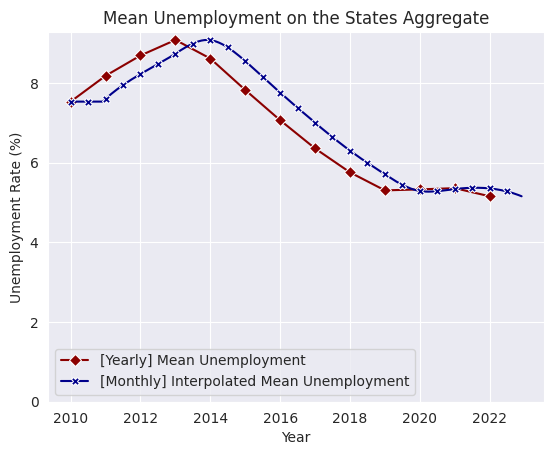

In [93]:
# economic visualization for sanity check
## grab orig data
orig_df = pd.read_csv(save_path.parent / "economic_data.csv")
orig_df["year"] = pd.to_datetime(orig_df["year"], format="%Y")

## create unemployment aggregates
orig_avg_unemployment = orig_df.groupby("year")["unemployment_rate"].mean().reset_index()
new_avg_unemployment = df.groupby("date")["unemployment_rate"].mean().reset_index()

## graphing
sns.set_style("darkgrid")
sns.lineplot(
    orig_avg_unemployment, x="year", y="unemployment_rate", marker="D",
    label="[Yearly] Mean Unemployment", color="darkred"
)
sns.lineplot(
    new_avg_unemployment, x="date", y="unemployment_rate", marker="X",
    label="[Monthly] Interpolated Mean Unemployment", color="darkblue",
    markevery=6
)

## graph metadata
plt.title("Mean Unemployment on the States Aggregate")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.ylim(bottom=0.0)
plt.legend()
plt.savefig(
    Path().cwd().parent / "visualizations" / "Unemployment Rates", dpi=400
)
plt.show()